# Importing libraries

In [ ]:
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
import skimage.color
from skimage.transform import resize,rotate
import cv2
from skimage.filters import gabor

# Importing given Images

In [ ]:
bird = cv2.imread("/content/bird.jpeg")
book = cv2.imread("/content/book.jpeg")
dog = cv2.imread("/content/dog.jpeg")
sunset = cv2.imread("/content/sunset.jpeg")

images = [bird,book,dog,sunset]

#Using RGB for similarity matrices

In [ ]:
# Similarity = comparing R+G+B/3

def similarity_matrix_rgb(image):
  r = image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
  r = np.sum(r,axis = 1)/3
  n = len(r)
  W = np.zeros((n,n))
  for i in range(n):
      for j in range(i+1, n):
          d = (r[i]-r[j])**2
          W[i, j] = np.exp(-d/5)
          W[j, i] = W[i, j]
  return W


#Using grayscale Intensity for similarity matrix

In [ ]:

def compute_similarity_gray(img,r,sigma_i,sigma_x):
  img= skimage.color.rgb2gray(img)
  m,n=img.shape
  threshold=r
  W=np.zeros((m*n,m*n))
  for i in range(m*n):
    row_i,col_i=divmod(i,n)
    for j in range(m*n):
      row_j,col_j=divmod(j,n)
      distance=np.sqrt((row_i-row_j)**2+(col_j-col_i)**2)
      if(distance<threshold and W[i][j]==0):
        intensity=np.abs((img[row_i][col_i]-img[row_j][col_j])/(sigma_i))
        W[i][j]=np.exp(-distance/sigma_x)*np.exp(-intensity)
        W[j][i]= W[i][j]
  return W

#Using Gabor Filters for similarity matrix

In [ ]:
def compute_gabor_features(gray_image):

    # Define parameters for Gabor filters
    frequencies = [0.1, 0.5]  # Adjust the frequencies as needed
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Adjust the angles as needed
    gabor_features = []
    # Apply Gabor filters and collect features
    for freq in frequencies:
        for angle in angles:
            gabor_filter_real, gabor_filter_imaginary = gabor(gray_image, frequency=freq, theta=angle)
            gabor_features.append(gabor_filter_real)
            gabor_features.append(gabor_filter_imaginary)
    # Stack the features along the channel dimension
    gabor_features = np.stack(gabor_features, axis=-1)
    return gabor_features

def similarity_matrix_gabor(image):
    image = skimage.color.rgb2gray(image)
    # Compute Gabor features
    gabor_features = compute_gabor_features(image)
    h, w, _ = gabor_features.shape
    # Flatten the feature vectors
    features_flat = gabor_features.reshape((h*w, -1))
    # Compute pairwise Euclidean distances between feature vectors
    pairwise_distances = np.sqrt(np.sum((features_flat[:, None, :] - features_flat) ** 2, axis=-1))
    # Compute similarity matrix based on Gaussian kernel
    similarity_matrix = np.exp(-pairwise_distances / 5)  # Adjust the parameter sigma as needed
    return similarity_matrix

# Normalized Cut Algorithm

In [ ]:
def normalized_cut(W):
  D = np.zeros(W.shape)
  D = np.diag(W.sum(axis=1))
  eigenvalues, eigenvectors = eigsh(D-W, k=2, M=D, which="SM")
  eigenvalues = eigenvalues[1]
  eigenvectors = eigenvectors[:,1]
  median = np.median(eigenvectors)
  out = np.reshape(eigenvectors,(50,50))
  out = np.where(out > median,1,0)
  return out


#Image Segmentation RGB

In [ ]:
def segmentation_rgb(image):
    width = 50
    height = 50

    dim = (width, height)
    b,g,r=cv2.split(image)
    image=cv2.merge([r,g,b])
    resized_image = cv2.resize(image,dim, interpolation = cv2.INTER_LANCZOS4)
    print(resized_image.shape)

    W = similarity_matrix_rgb(resized_image)

    # Perform image segmentation using the N-Cut algorithm
    rgb_segmented = normalized_cut(W)

    fig, axis = plt.subplots(ncols = 2, squeeze = False, figsize = (10,10))
    axis[0,0].imshow(image)
    axis[0,1].imshow(rgb_segmented)
    axis[0,0].title.set_text('Original Image')
    axis[0,1].title.set_text('RGB Similarity')
    plt.show()


(50, 50, 3)


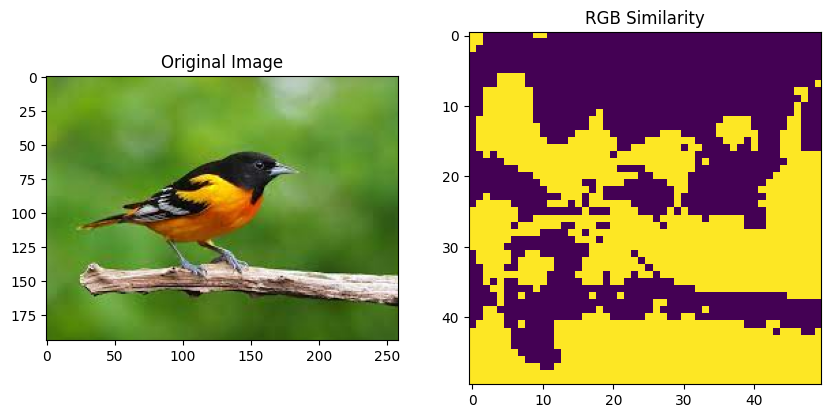

(50, 50, 3)


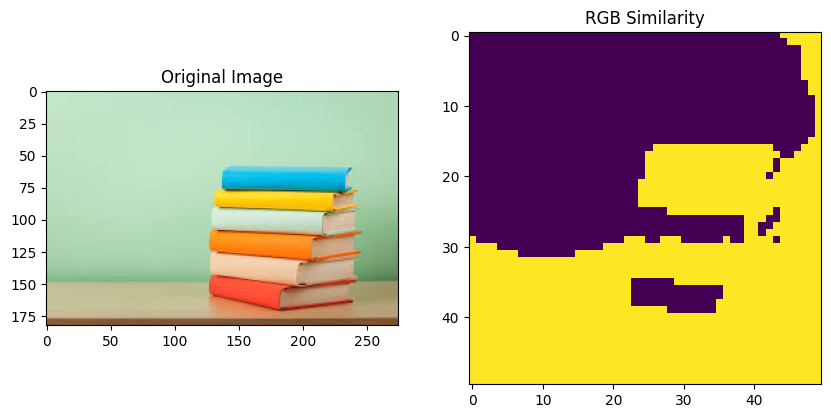

(50, 50, 3)


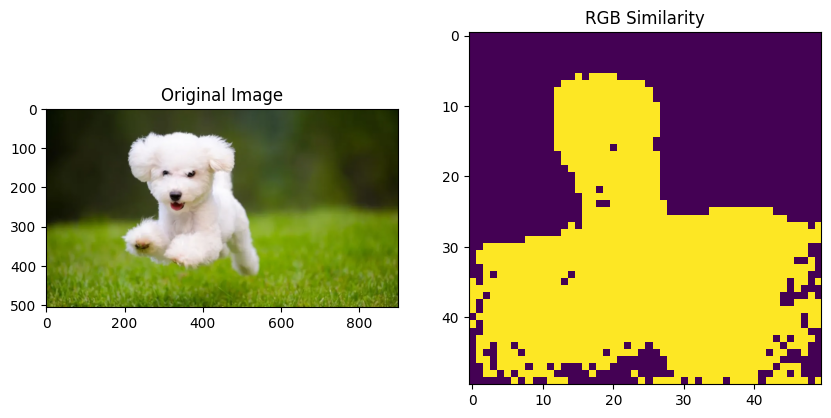

(50, 50, 3)


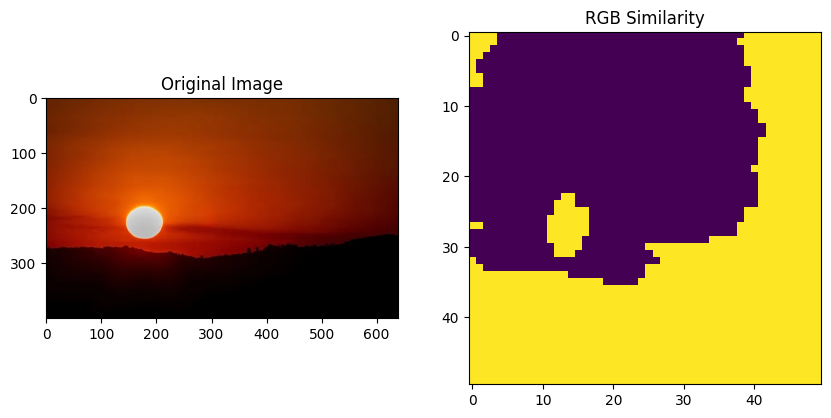

In [ ]:
for img in images:
  segmentation_rgb(img)

In [ ]:
def segmentation_gray(image,param):
    width = 50
    height = 50

    dim = (width, height)
    b,g,r=cv2.split(image)
    image=cv2.merge([r,g,b])
    print(image.shape)
    resized_image = cv2.resize(image,dim, interpolation = cv2.INTER_LANCZOS4)
    print(resized_image.shape)

    W = compute_similarity_gray(resized_image,param[0],param[1],param[2])


    # Perform image segmentation using the N-Cut algorithm
    gray_segmented = normalized_cut(W)

    fig, axis = plt.subplots(ncols = 2, squeeze = False, figsize = (10,10))
    axis[0,0].imshow(image)
    axis[0,1].imshow(gray_segmented)
    axis[0,0].title.set_text('Original Image')
    axis[0,1].title.set_text('Gray Similarity')
    plt.show()


(194, 259, 3)
(50, 50, 3)


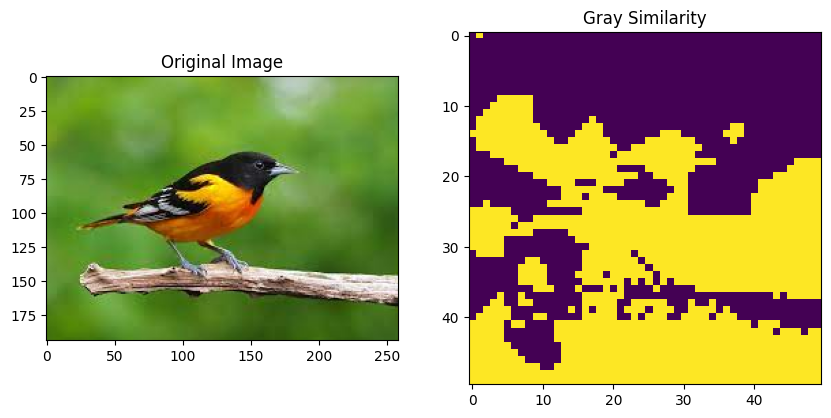

(183, 275, 3)
(50, 50, 3)


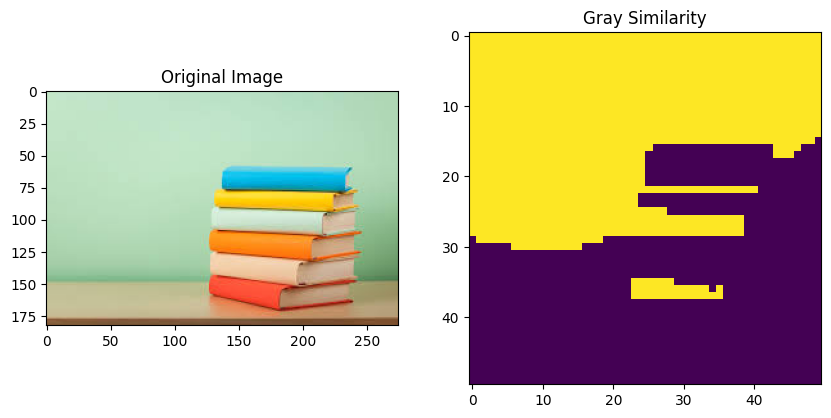

(507, 900, 3)
(50, 50, 3)


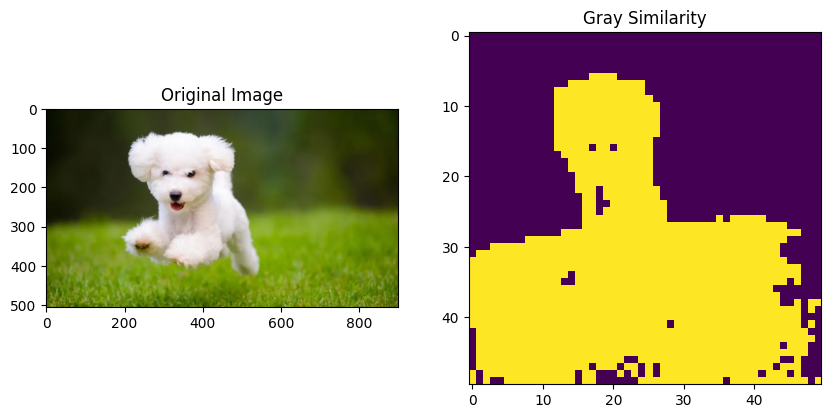

(400, 640, 3)
(50, 50, 3)


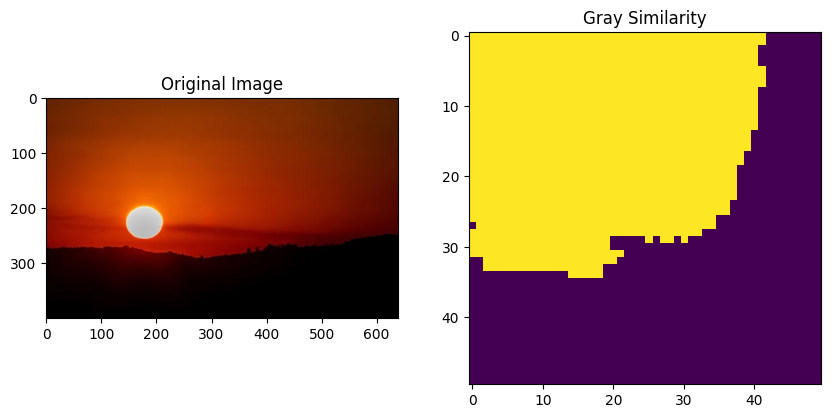

In [ ]:
params = [(30,0.01,4),(30,0.01,4),(30,.1,100),(35,0.01,4)]
for i,img in enumerate(images):
  segmentation_gray(img,params[i])

#Segmentation using Gabor Filters

In [ ]:
def segmentation_gabor(image):
    width = 50
    height = 50

    dim = (width, height)
    b,g,r=cv2.split(image)
    image=cv2.merge([r,g,b])
    print(image.shape)
    resized_image = cv2.resize(image,dim, interpolation = cv2.INTER_LANCZOS4)
    print(resized_image.shape)

    W = similarity_matrix_gabor(resized_image)


    # Perform image segmentation using the N-Cut algorithm
    gabor_segment = normalized_cut(W)

    fig, axis = plt.subplots(ncols = 2, squeeze = False, figsize = (10,10))
    axis[0,0].imshow(image)
    axis[0,1].imshow(gabor_segment)
    axis[0,0].title.set_text('Original Image')
    axis[0,1].title.set_text('Gabor Similarity')
    plt.show()

(194, 259, 3)
(50, 50, 3)


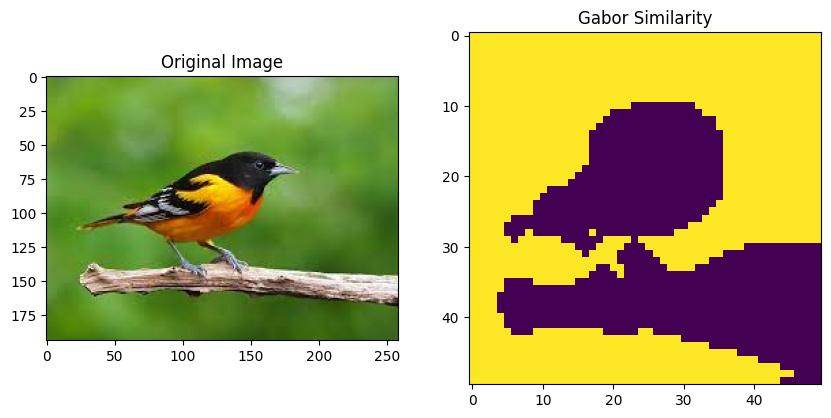

(183, 275, 3)
(50, 50, 3)


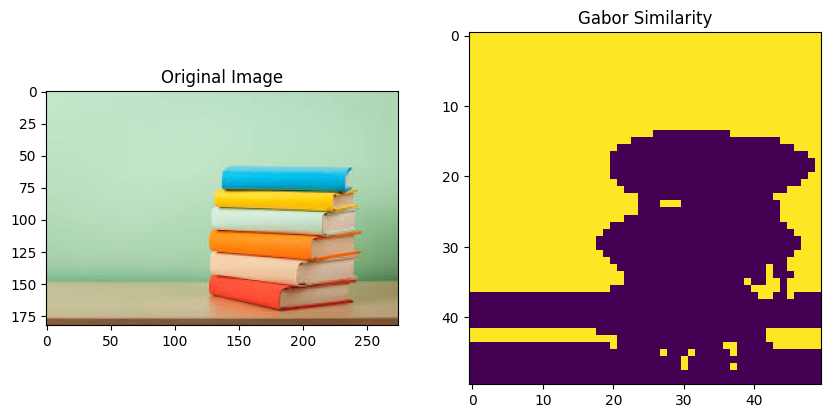

(507, 900, 3)
(50, 50, 3)


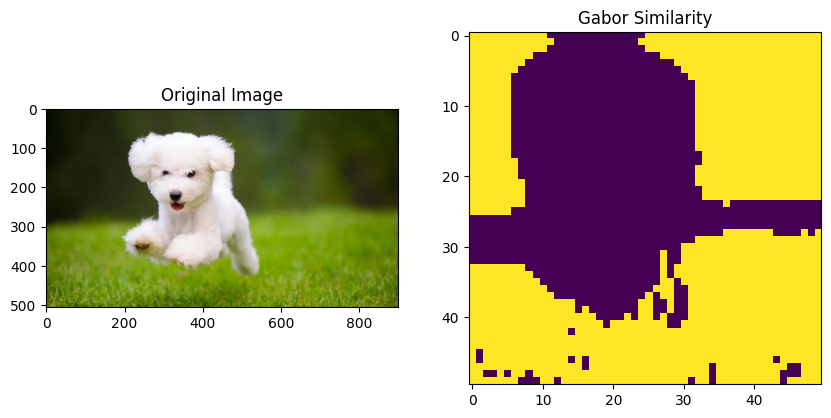

(400, 640, 3)
(50, 50, 3)


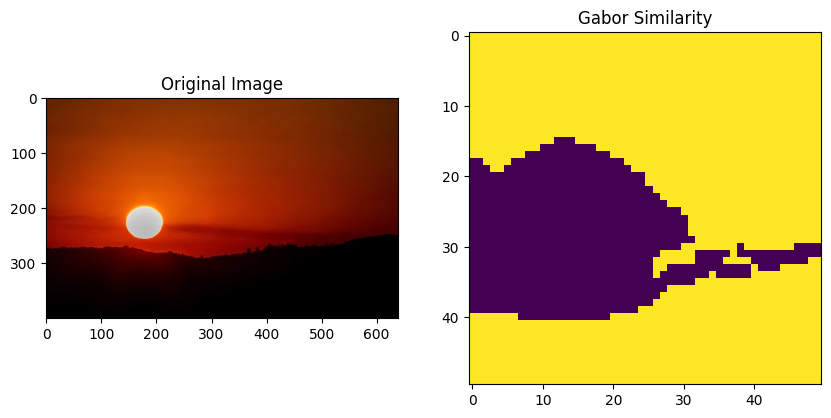

In [ ]:
for img in images:
  segmentation_gabor(img)

# 3 or more segments

In [ ]:
def normalized_cut_4_segments(W):
  D = np.zeros(W.shape)
  D = np.diag(W.sum(axis=1))
  eigenvalues, eigenvectors = eigsh(D-W, k=4, M=D, which="SM")
  eigenvalues = eigenvalues[1]
  eigenvectors = np.real(eigenvectors[:,1:4])
  median = np.median(eigenvectors,axis=0)
  print(median.shape)
  class_mean = np.mean(eigenvectors,axis = 1)
  print(class_mean.shape)
  new_median = np.sort(median)
  for i in class_mean:
    if(i < new_median[0]):
      i = 0
    elif(i<new_median[1]):
      i = 1
    elif(i<new_median[2]):
      i = 2
    else:
      i = 3
  out = np.reshape(class_mean,(50,50))
  return out



In [ ]:
def segmentation_4_segments(image):
    width = 50
    height = 50

    dim = (width, height)
    b,g,r=cv2.split(image)
    image=cv2.merge([r,g,b])
    resized_image = cv2.resize(image,dim, interpolation = cv2.INTER_LANCZOS4)
    print(resized_image.shape)

    W = similarity_matrix_rgb(resized_image)

    # Perform image segmentation using the N-Cut algorithm
    rgb_segmented = normalized_cut_4_segments(W)

    fig, axis = plt.subplots(ncols = 2, squeeze = False, figsize = (10,10))
    axis[0,0].imshow(image)
    axis[0,1].imshow(rgb_segmented)
    axis[0,0].title.set_text('Original Image')
    axis[0,1].title.set_text('RGB Similarity')
    plt.show()

(50, 50, 3)
(3,)
(2500,)


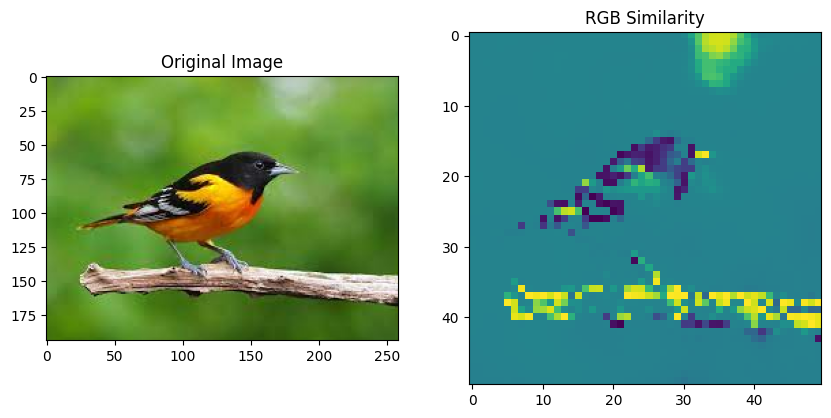

(50, 50, 3)
(3,)
(2500,)


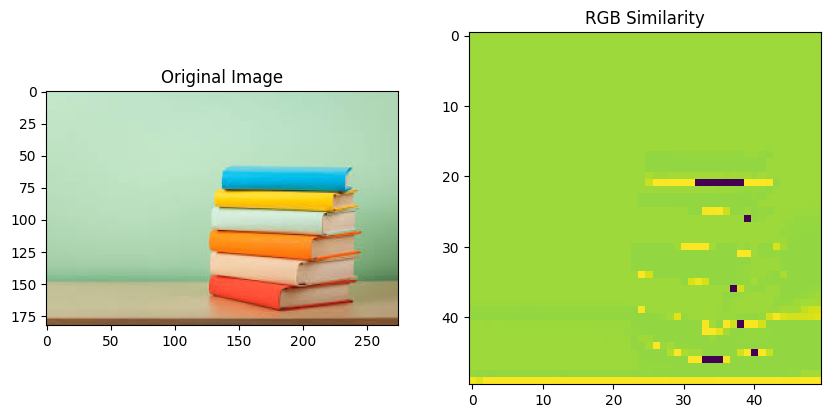

(50, 50, 3)
(3,)
(2500,)


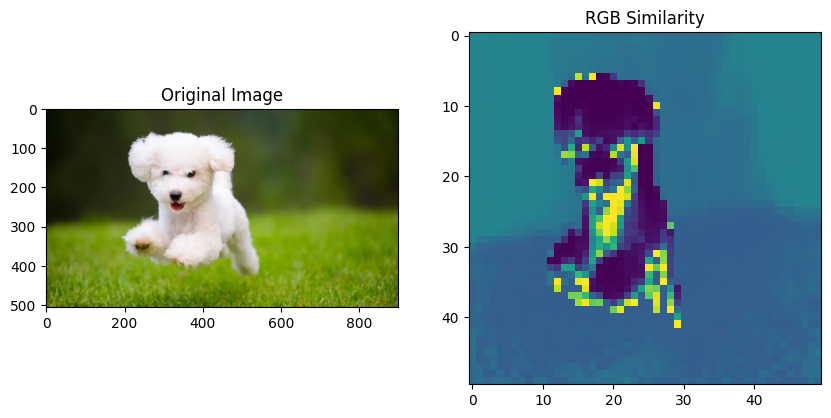

(50, 50, 3)
(3,)
(2500,)


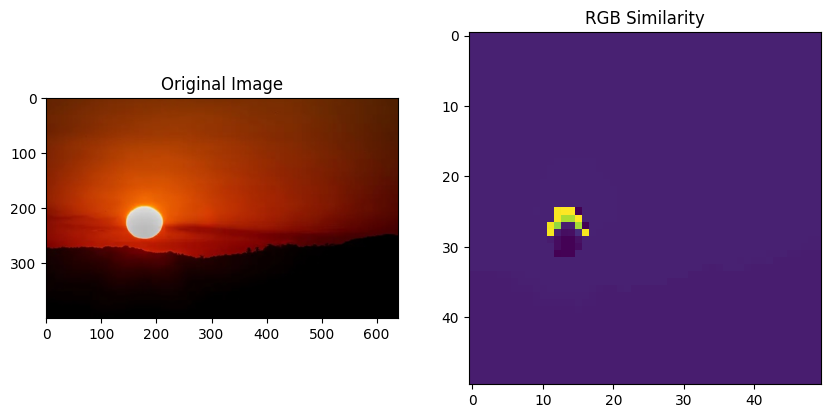

In [ ]:
for img in images:
  segmentation_4_segments(img)

In [ ]:
def segmentation_k_means(image,i):
    image_shape = image.shape
    image = image.reshape((-1, 3))
    image = np.float32(image)
    fig, axis = plt.subplots(nrows = 1,ncols = 4, squeeze = False, figsize = (10,10))

    # Define the criteria for k-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

    # Perform k-means clustering
    k = 3
    for k in [3,4,5,6]:
      retval, labels, centers = cv2.kmeans(image, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

      # Convert data into 8-bit values
      centers = np.uint8(centers)
      segmented_data = centers[labels.flatten()]

      # Reshape data into the original image dimensions
      segmented_image = segmented_data.reshape(image_shape)
    # Display the segmented image
      # cv2_imshow(segmented_image)
      axis[0,k-3].imshow(segmented_image)

      axis[0,0].title.set_text('K == 3')
      axis[0,1].title.set_text('K == 4')
      axis[0,2].title.set_text('K == 5')
      axis[0,3].title.set_text('K == 6')
    plt.show()

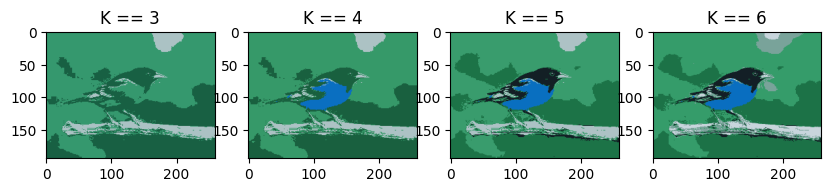

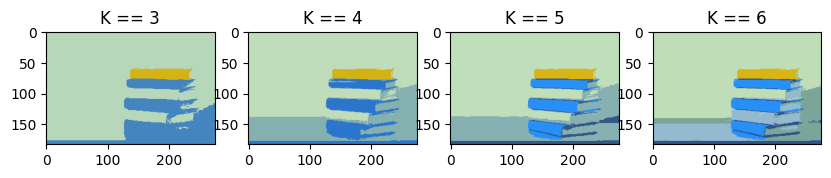

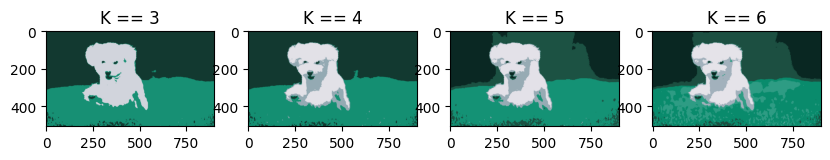

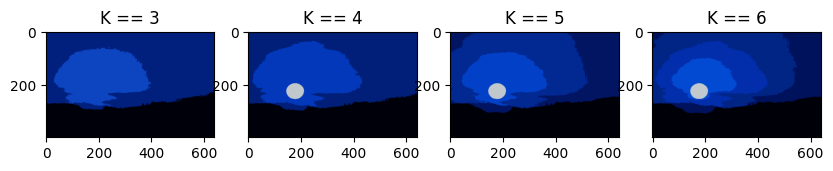

In [ ]:
for i,img in enumerate(images):
  segmentation_k_means(img,i)